<a href="https://colab.research.google.com/github/MohebZandi/Comupter_Vision/blob/main/Re_Train_Object_detection_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#How to retrain an object detection model with a custom training set

Kosta Malsev  ---  Jan 13, 2021



## **Step 1**: Clone TensorFlow2 object detection API folder to your colab:

In [1]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3313, done.
remote: Counting objects: 100% (3313/3313), done.
remote: Compressing objects: 100% (2735/2735), done.
remote: Total 3313 (delta 876), reused 1387 (delta 529), pack-reused 0
Receiving objects: 100% (3313/3313), 34.29 MiB | 11.88 MiB/s, done.
Resolving deltas: 100% (876/876), done.


## **Step 2**: Install object detection API in colab:

### Note: unfortunately, for some reason, you need to run the step twice to fix errors in installation.

In [2]:
# Install the Object Detection API
%%bash
cd /content/models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1685593 sha256=907b35fb971af6014e321febbb2fdf41576b8508d047b5755504d0f8d1db9fc1
  Stored in directory: /tmp/pip-ephem-wheel-cache-42f8vg49/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=b66e3c7bef289f86121db6736259d1b8ca5abda37efca2d020fcb7e0fd5aaae5
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=38250e2d18f8313ba4908c2e9b243ed7433aca7233bb64a1fcc214e936746d2f
  Stored in directory: /root/.cache/pip/wheels/a4/61/fd/c57e374e580aa78a45ed78d5859b3a44436af17e22ca53284f
  Created wheel for avro-python3: filename=avro_python3-1.10.2-py3-none-any.whl size=44010 sha256=1281a82e36cbfa062f9a3f8554d03fc89b3d83631e79c1548f

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.0.0 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## **Step 3**: Import the TensorFlow libraries to colab:

In [3]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

## **Step 4**: Run this command to test if object detection API is installed properly:

In [4]:
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py

2022-04-06 13:39:02.711409: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Running tests under Python 3.7.13: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
W0406 13:39:03.325073 140061426747264 model_builder.py:1102] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 0.94s
I0406 13:39:03.662881 140061426747264 test_util.py:2374] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 0.94s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 0.69s
I0406 13:39:04.350727 140061426747264 test_util.py:2374] time(__main__.ModelBuilderTF2Test.test_cr

## Prepare Tensorflow 2 Object Detection Training Data

We are going to use Roboflow to generate image data set and convert it to TFrecords format.

In [5]:
#Downloading data Training set made by Roboflow
%cd /content

#Download Training set from git by cloning rep:
import os
import pathlib
# Clone the training set repository if it doesn't already exist
if "RetrainModelExample" in pathlib.Path.cwd().parts:
  while "RetrainModelExample" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('RetrainModelExample').exists():
  !git clone --depth 1 https://github.com/KostaMalsev/RetrainModelExample
  %cd /content/RetrainModelExample/TrainingSet/Picka 
  !unzip Pickachu2.v1.tfrecord.zip -d /content/

#NOTE: Update these TFRecord names to your files containing training set!
#Also, Update relevant rows:in training config file "ssd_mobilenet_v2_320x320_coco17_tpu-8.config"
#label_map_path,input_path 
test_record_fname = '/content/valid/Toy.tfrecord'
train_record_fname = '/content/train/Toy.tfrecord'
label_map_pbtxt_fname = '/content/train/Toy_label_map.pbtxt'

#test_record_fname = '/content/valid/pieces.tfrecord'
#train_record_fname = '/content/train/toymnm.tfrecord'
#label_map_pbtxt_fname = '/content/train/toymnm_label_map.pbtxt'

/content
Cloning into 'RetrainModelExample'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 22 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), done.
/content/RetrainModelExample/TrainingSet/Picka
Archive:  Pickachu2.v1.tfrecord.zip
 extracting: /content/README.roboflow.txt  
   creating: /content/train/
 extracting: /content/train/Toy.tfrecord  
 extracting: /content/train/Toy_label_map.pbtxt  


## Configure Custom TensorFlow2 Object Detection Training

In this section we specify configuration for mobilentV2 model. for additional models see TF2 OD model zoo.

## **Step 6**: Set configuration parameters for training the model:

In [6]:
#We choose mobilentv2 model to deploy from TF2 object detection zoo
MODELS_CONFIG = {
    'ssd_mobilenet_v2_320x320_coco17': {
        'model_name': 'ssd_mobilenet_v2_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz',
        'batch_size': 16
    }
}
#'batchsize 512 19/10/20
chosen_model = 'ssd_mobilenet_v2_320x320_coco17'

num_steps = 1800 #40000 #The more steps, the longer the training. Increase if your loss function is still decreasing and validation metrics are increasing. 
num_eval_steps = 500 #Perform evaluation after so many steps

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
batch_size = MODELS_CONFIG[chosen_model]['batch_size'] #if you can fit a large batch in memory, it may speed up your trainin#g
#base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']

## **Step 7**: Load trained model weights from TensorFlow site, and the custom configuration file which I’ve prepared for this example:

In [7]:
#Download pretrained weights
%mkdir /content/deploy/
%cd /content/deploy/
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint

!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()
#Shorten the folder name,because long file paths are not yet supported :(
os.rename('ssd_mobilenet_v2_320x320_coco17_tpu-8','mobilnetv2')

/content/deploy
--2022-04-06 13:40:02--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 64.233.189.128, 2404:6800:4008:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|64.233.189.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46042990 (44M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_32 100%[===================>]  43.91M   111MB/s    in 0.4s    

2022-04-06 13:40:03 (111 MB/s) - ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz’ saved [46042990/46042990]



In [8]:
#Download training configuration file for mobilenetV2. 
#note: configuration file contain references to your trainig set of images,
#you can change it for your dataset.
%cd /content/deploy
download_config = 'https://raw.githubusercontent.com/KostaMalsev/RetrainModelExample/main/ssd_mobilenet_v2_320x320_coco17_tpu-8.config'
!wget {download_config}

/content/deploy
--2022-04-06 13:40:04--  https://raw.githubusercontent.com/KostaMalsev/RetrainModelExample/main/ssd_mobilenet_v2_320x320_coco17_tpu-8.config
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4737 (4.6K) [text/plain]
Saving to: ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.config’

ssd_mobilenet_v2_32 100%[===================>]   4.63K  --.-KB/s    in 0s      

2022-04-06 13:40:04 (35.0 MB/s) - ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.config’ saved [4737/4737]



In [9]:
#Prepare loaded model for retraining
fine_tune_checkpoint = '/content/deploy/mobilnetv2/checkpoint/ckpt-0'
pipeline_file = '/content/deploy/ssd_mobilenet_v2_320x320_coco17_tpu-8.config'
model_dir = '/content/training/'

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_pbtxt_fname)

In [10]:
#Check if all configuration is OK:
print(fine_tune_checkpoint)
print(train_record_fname)
print(label_map_pbtxt_fname)
print(batch_size)
print(num_steps)
print(num_classes)
print(pipeline_file)
print(model_dir)

/content/deploy/mobilnetv2/checkpoint/ckpt-0
/content/train/Toy.tfrecord
/content/train/Toy_label_map.pbtxt
16
1800
1
/content/deploy/ssd_mobilenet_v2_320x320_coco17_tpu-8.config
/content/training/


## Train Custom TF2 Object Detector

- pipeline_file: defined above in writing custom training configuration

- model_dir: the location tensorboard logs and saved model checkpoints will save to

- num_train_steps: how long to train for

- num_eval_steps: perform eval on validation set after this many steps

In [11]:
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps}

Traceback (most recent call last):
  File "/content/models/research/object_detection/model_main_tf2.py", line 31, in <module>
    from object_detection import model_lib_v2
  File "/usr/local/lib/python3.7/dist-packages/object_detection/model_lib_v2.py", line 29, in <module>
    from object_detection import eval_util
  File "/usr/local/lib/python3.7/dist-packages/object_detection/eval_util.py", line 36, in <module>
    from object_detection.metrics import lvis_evaluation
  File "/usr/local/lib/python3.7/dist-packages/object_detection/metrics/lvis_evaluation.py", line 23, in <module>
    from lvis import results as lvis_results
  File "/usr/local/lib/python3.7/dist-packages/lvis/__init__.py", line 5, in <module>
    from lvis.vis import LVISVis
  File "/usr/local/lib/python3.7/dist-packages/lvis/vis.py", line 1, in <module>
    import cv2
  File "/usr/local/lib/python3.7/dist-packages/cv2/__init__.py", line 9, in <module>
    from .cv2 import _registerMatType
ImportError: cannot import n

In [12]:
#Your trained weights will be in this directory:
%ls -l '/content/training/'

ls: cannot access '/content/training/': No such file or directory


In [13]:
#Run conversion script to save the retrained model:
#Saved model will be in saved_model.pb file:

import re
import numpy as np

output_directory = '/content/fine_tuned_model'

#place the model weights you would like to export here
last_model_path = '/content/training/'
print(last_model_path)
!python /content/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

/content/training/
2022-04-06 13:40:13.415266: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0406 13:40:13.610454 140707857467264 deprecation.py:615] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:458: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
INFO:tensorflow:depth of additional conv before box predictor: 0
I0406

In [14]:
%ls '/content/fine_tuned_model/saved_model/'

ls: cannot access '/content/fine_tuned_model/saved_model/': No such file or directory


## Run Inference on Test Images with Custom TensorFlow2 Object Detector

In [15]:
#Import your test images to colab. I use pinterest to store the the images. 
%mkdir /content/test/
%cd /content/test/
#M&M toy:
#!curl -L "https://i.pinimg.com/originals/4c/6a/00/4c6a0021a735e1dcb9edcb6715467e15.jpg" > test.jpeg;
#Pickachu toy:
!curl -L "https://i.pinimg.com/564x/f5/46/c4/f546c47505e1f5f8d17f8458d641b262.jpg" > te

/content/test
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 66488  100 66488    0     0   108k      0 --:--:-- --:--:-- --:--:--  108k


In [16]:
import os 
import glob
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [23]:
#Recover our saved model with the latest checkpoint:
pipeline_config = pipeline_file
#Put the last ckpt from training in here, don't use long pathnames:
model_dir = '/content/RetrainModelExample/checkpoint/ckpt-0.index'
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore last checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
#ckpt.restore(os.path.join(model_dir))
ckpt.restore(model_dir)

#Function perform detection of the object on image in tensor format: 
def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""
    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn
  
#Define function which performs detection: 
detect_fn = get_model_detection_function(detection_model)

In [24]:
#map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

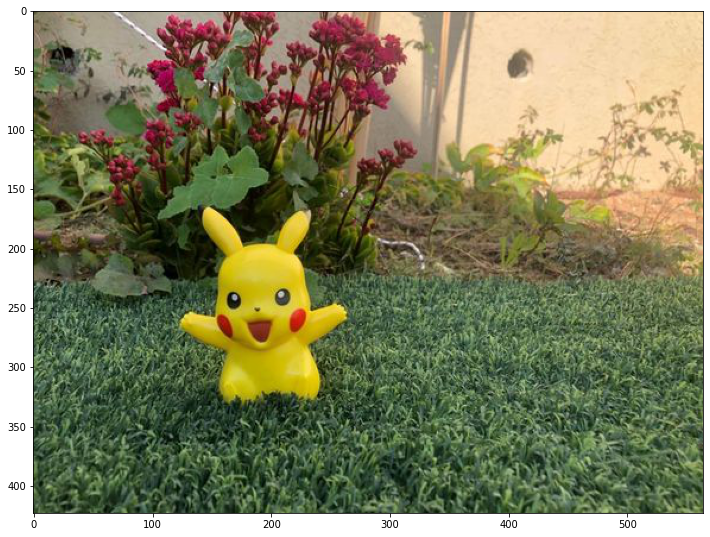

In [27]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 
import random

#Define utility functions for presenting the results:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.
  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.
  Args:
    path: the file path to the image
  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


#Place your test images here:
image_path = '/content/test/te'

#Store test images in nmpy array:
image_np = load_image_into_numpy_array(image_path)

#Convert images to tensor form:
input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)

#Perform detection on the image in tensor format:
detections, predictions_dict, shapes = detect_fn(input_tensor)

#Visualize the detection boxes on the image:
label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=0.70,#0.5,#0.5
      agnostic_mode=False,
)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()